# Introduction
The dataset that I am using is from the Kaggle Competition. 
What I am trying to do is to group Articles based off of their titles into 5 different categories. I will be using hierarchical clustering, specifically Ward method, Complete, and Average to accomplish this. The goal is to get as accurate as possible with one of these three models.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
# Load dataset
file_path = '/kaggle/input/learn-ai-bbc/BBC News Train.csv'
df = pd.read_csv(file_path)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)

Dataset Shape: (1490, 3)

Column Data Types:
 ArticleId     int64
Text         object
Category     object
dtype: object


In [3]:
display(df.head())
df.isnull().sum()
print(df.info())

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


# EDA Section

In [4]:
#Converting text data into numerical data for Hierarchical clustering

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(tokens)

df["cleaned_text"] = df["Text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#Getting the most common words in each category
from collections import Counter

word_counts = Counter(" ".join(df["cleaned_text"]).split())
print(word_counts.most_common(20))  # Print top 20 most common words

[('said', 4839), ('mr', 1974), ('would', 1714), ('year', 1528), ('also', 1426), ('new', 1338), ('people', 1324), ('us', 1264), ('one', 1245), ('could', 1032), ('first', 934), ('last', 893), ('two', 889), ('time', 882), ('world', 805), ('uk', 781), ('government', 752), ('film', 646), ('years', 644), ('best', 642)]


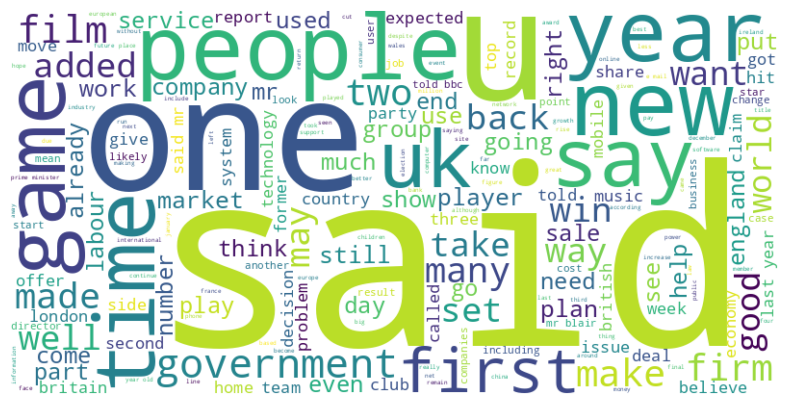

In [6]:
#Displaying a wordcloud of all of the words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["cleaned_text"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important words
X_tfidf = vectorizer.fit_transform(df["cleaned_text"]).toarray()

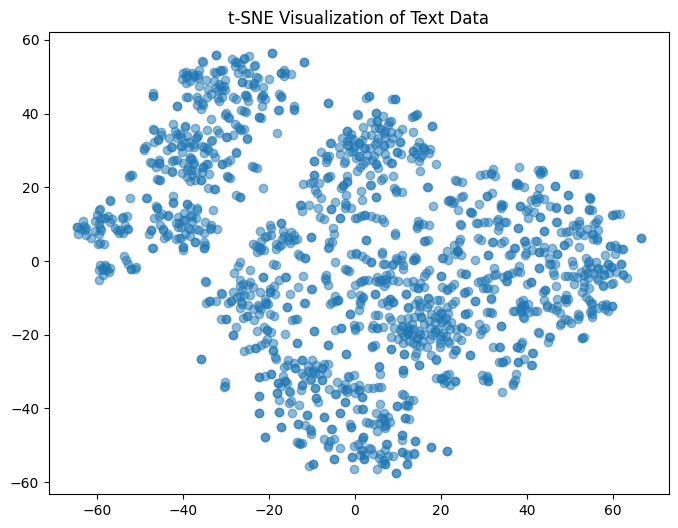

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_tfidf)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Text Data")
plt.show()

# Ward's Method

In [9]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute Euclidean distance matrix
distance_matrix = pdist(X_tfidf, metric="euclidean")  # No need for .toarray()

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method="ward")

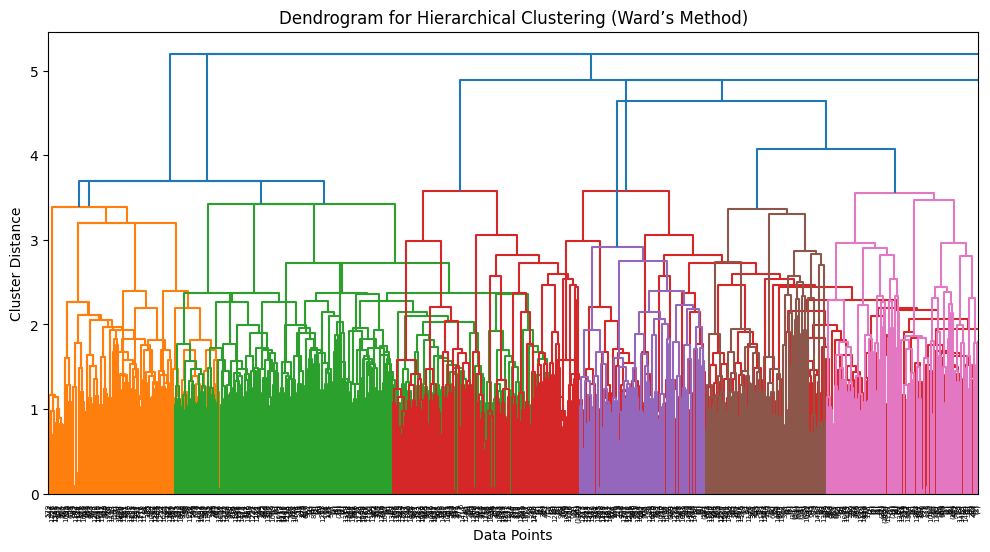

In [10]:
# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
dendrogram(linkage_matrix, truncate_mode="level", p=10)  # Limit depth to 5 levels
plt.title("Dendrogram for Hierarchical Clustering (Ward’s Method)")
plt.xlabel("Data Points")
plt.ylabel("Cluster Distance")
plt.show()

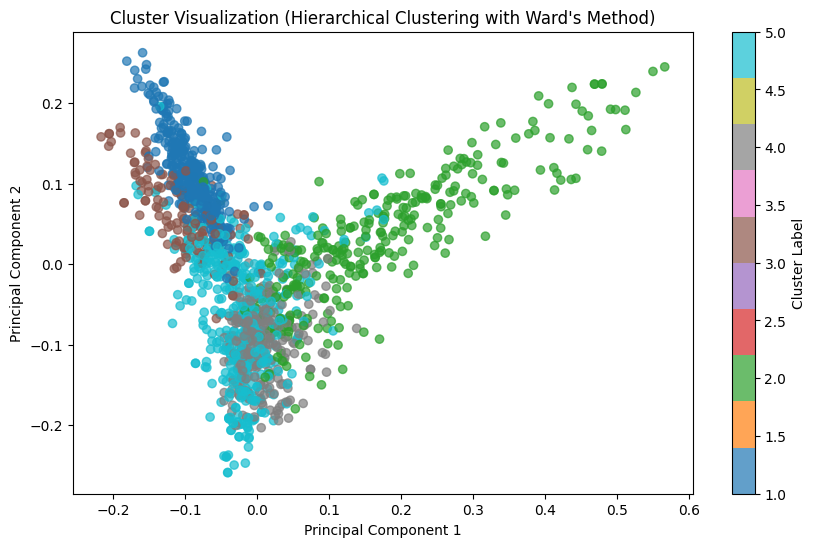

In [11]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA

# Extract cluster labels (e.g., assume we want 5 clusters)
num_clusters = 5  # Adjust if needed
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

# Reduce dimensions using PCA (for visualization)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_tfidf)

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("Cluster Visualization (Hierarchical Clustering with Ward's Method)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [12]:
from scipy.cluster.hierarchy import fcluster

num_clusters = 5  # 5 categories we want to predict for
clusters = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

# Assign clusters to the dataframe
df["Cluster"] = clusters

# Display the first 10 rows of the Text and Cluster columns
print(df[["Text", "Cluster"]].head(10))
  

                                                Text  Cluster
0  worldcom ex-boss launches defence lawyers defe...        4
1  german business confidence slides german busin...        4
2  bbc poll indicates economic gloom citizens in ...        2
3  lifestyle  governs mobile choice  faster  bett...        5
4  enron bosses in $168m payout eighteen former e...        4
5  howard  truanted to play snooker  conservative...        2
6  wales silent on grand slam talk rhys williams ...        1
7  french honour for director parker british film...        3
8  car giant hit by mercedes slump a slump in pro...        4
9  fockers fuel festive film chart comedy meet th...        3


In [13]:

# Compare clusters with actual labels by counting the category distribution in each cluster
print(df.groupby("Cluster")["Category"].value_counts())

Cluster  Category     
1        sport            324
         politics           2
         business           1
         entertainment      1
2        politics         236
         business          58
         tech              12
         sport              2
         entertainment      1
3        entertainment    130
         tech               6
4        business         252
         politics           7
         tech               5
         entertainment      2
         sport              1
5        tech             238
         entertainment    139
         politics          29
         business          25
         sport             19
Name: count, dtype: int64


# Complete linkage

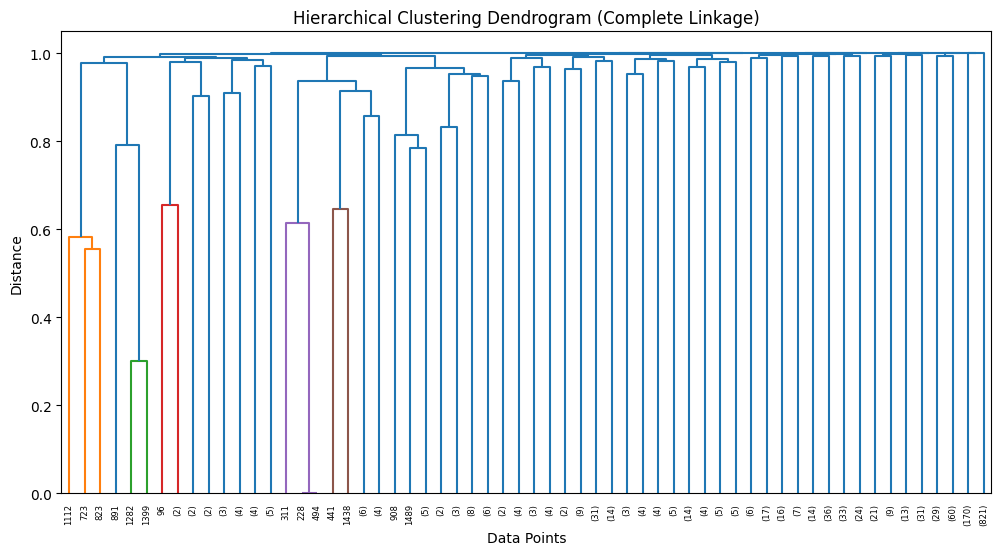

Cluster_Complete  Category     
1                 sport            346
                  business         336
                  politics         274
                  entertainment    273
                  tech             261
Name: count, dtype: int64


In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Compute distance matrix
distance_matrix = pdist(X_tfidf, metric="cosine")

# Perform hierarchical clustering using Complete linkage
linkage_complete = linkage(distance_matrix, method="complete")

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_complete, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Extract clusters
clusters_complete = fcluster(linkage_complete, 5, criterion="maxclust")
df["Cluster_Complete"] = clusters_complete

# Check cluster distribution
print(df.groupby("Cluster_Complete")["Category"].value_counts())

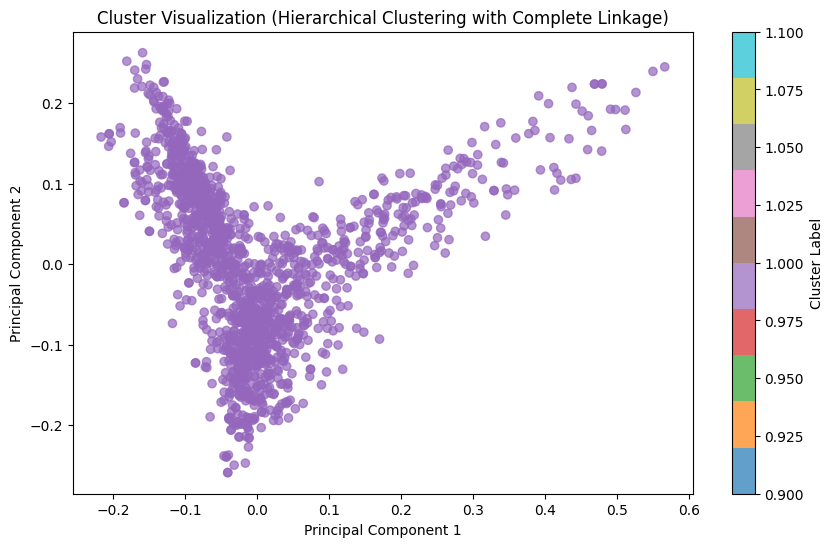

Cluster_Complete  Category     
1                 sport            346
                  business         336
                  politics         274
                  entertainment    273
                  tech             261
Name: count, dtype: int64


In [24]:
# Extract clusters (e.g., assume we want 5 clusters)
num_clusters = 5
clusters_complete = fcluster(linkage_complete, num_clusters, criterion="maxclust")

# Add clusters to dataframe
df["Cluster_Complete"] = clusters_complete

# Reduce dimensions using PCA (for visualization)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_tfidf)  # Convert sparse matrix to dense for PCA

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters_complete, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("Cluster Visualization (Hierarchical Clustering with Complete Linkage)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Check cluster distribution
print(df.groupby("Cluster_Complete")["Category"].value_counts())

In [25]:
# Assign clusters to the dataframe
df["Cluster (Complete)"] = clusters_complete
# Display the first 10 rows of the Text and Cluster columns
print(df[["Text", "Cluster (Complete)"]].head(10))

                                                Text  Cluster (Complete)
0  worldcom ex-boss launches defence lawyers defe...                   1
1  german business confidence slides german busin...                   1
2  bbc poll indicates economic gloom citizens in ...                   1
3  lifestyle  governs mobile choice  faster  bett...                   1
4  enron bosses in $168m payout eighteen former e...                   1
5  howard  truanted to play snooker  conservative...                   1
6  wales silent on grand slam talk rhys williams ...                   1
7  french honour for director parker british film...                   1
8  car giant hit by mercedes slump a slump in pro...                   1
9  fockers fuel festive film chart comedy meet th...                   1


In [26]:
# Compare clusters with actual labels by counting the category distribution in each cluster
print(df.groupby("Cluster (Complete)")["Category"].value_counts())

Cluster (Complete)  Category     
1                   sport            346
                    business         336
                    politics         274
                    entertainment    273
                    tech             261
Name: count, dtype: int64


# Average linkage

In [27]:
# Perform hierarchical clustering using Average linkage
linkage_matrix_avg = linkage(distance_matrix, method="average")

# Extract cluster labels (e.g., assume we want 5 clusters)
cluster_labels_avg = fcluster(linkage_matrix_avg, num_clusters, criterion="maxclust")

# Reduce dimensions using PCA (for visualization)
X_reduced_avg = pca.fit_transform(X_tfidf)

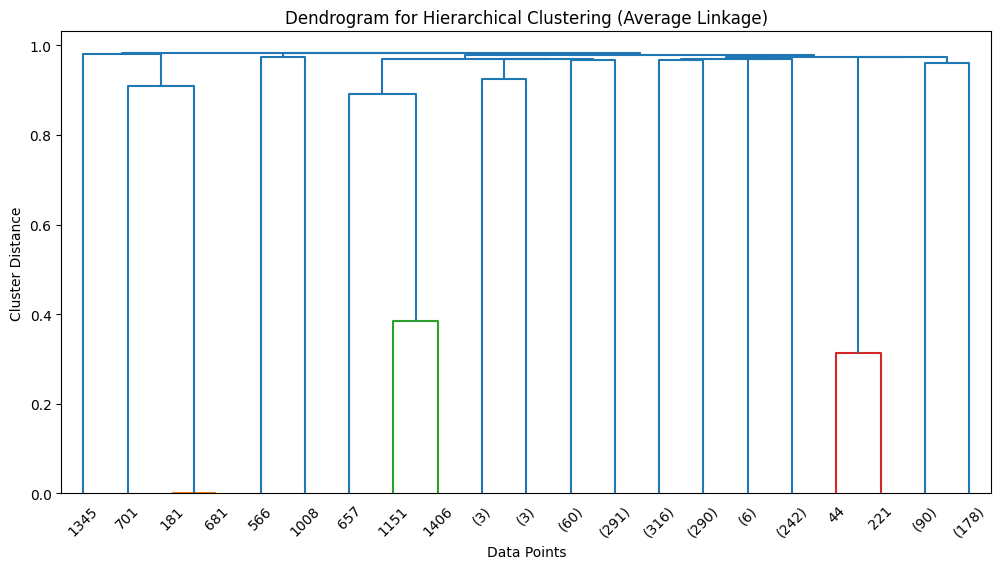

In [28]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

# Perform hierarchical clustering using Average linkage
linkage_matrix_avg = linkage(distance_matrix, method="average")

# Extract cluster labels (assume we want 5 clusters, as there are 5 categories)
num_clusters = 5
clusters_avg = fcluster(linkage_matrix_avg, num_clusters, criterion="maxclust")

# Optionally, plot the dendrogram for visualizing the hierarchical structure
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_avg, truncate_mode="level", p=5)  # Limit depth to 5 levels
plt.title("Dendrogram for Hierarchical Clustering (Average Linkage)")
plt.xlabel("Data Points")
plt.ylabel("Cluster Distance")
plt.show()


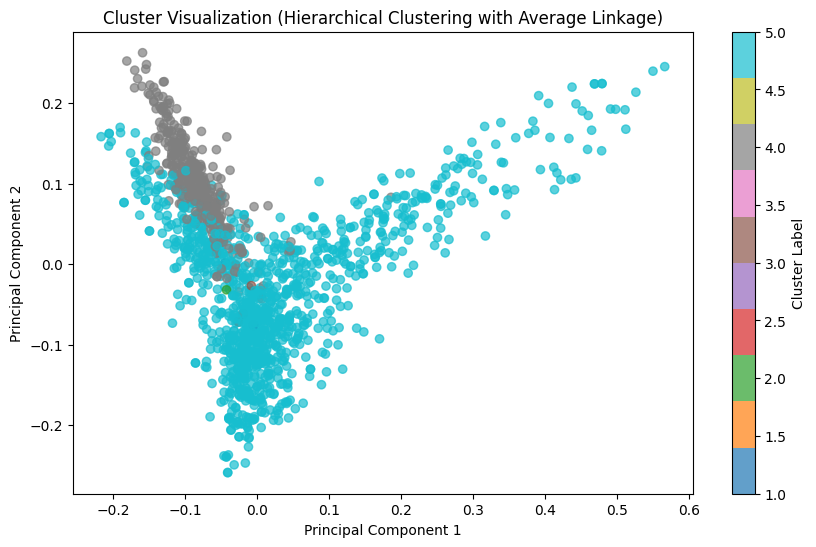

In [29]:
# Plot the clusters
plt.figure(figsize=(10, 6))
scatter_avg = plt.scatter(X_reduced_avg[:, 0], X_reduced_avg[:, 1], c=cluster_labels_avg, cmap="tab10", alpha=0.7)
plt.colorbar(scatter_avg, label="Cluster Label")
plt.title("Cluster Visualization (Hierarchical Clustering with Average Linkage)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [30]:

# Assign clusters to the dataframe
df["Cluster (Average)"] = clusters_avg

# Display the first 10 rows of the Text and Cluster columns
print(df[["Text", "Cluster (Average)"]].head(10))


                                                Text  Cluster (Average)
0  worldcom ex-boss launches defence lawyers defe...                  5
1  german business confidence slides german busin...                  5
2  bbc poll indicates economic gloom citizens in ...                  5
3  lifestyle  governs mobile choice  faster  bett...                  5
4  enron bosses in $168m payout eighteen former e...                  5
5  howard  truanted to play snooker  conservative...                  5
6  wales silent on grand slam talk rhys williams ...                  4
7  french honour for director parker british film...                  5
8  car giant hit by mercedes slump a slump in pro...                  5
9  fockers fuel festive film chart comedy meet th...                  5


In [31]:

# Compare clusters with actual labels by counting the category distribution in each cluster
print(df.groupby("Cluster (Average)")["Category"].value_counts())

Cluster (Average)  Category     
1                  tech               2
                   entertainment      1
2                  tech               1
3                  business           2
4                  sport            342
                   business          10
                   politics           4
                   entertainment      2
                   tech               2
5                  business         324
                   entertainment    270
                   politics         270
                   tech             256
                   sport              4
Name: count, dtype: int64


# Now working on test.csv

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

In [34]:
test_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")


In [36]:
#Converting text data into numerical data for Hierarchical clustering

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")

# Remove columns with all null values
df = df.dropna(axis=1, how='all')  # Drop columns that have all null values


def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(tokens)

df["cleaned_text"] = df["Text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
#Getting the most common words in each category
from collections import Counter

word_counts = Counter(" ".join(df["cleaned_text"]).split())

In [38]:
# Vectorize the test data using the same TF-IDF vectorizer fitted on the training data
X_test_tfidf = vectorizer.transform(test_df['Text'])

In [39]:
# Compute cosine distance matrix for test data
distance_matrix_test = pdist(X_test_tfidf.toarray(), metric="cosine")


In [41]:
# Apply Ward's method (just as we did for the training data)
linkage_matrix_test_ward = linkage(distance_matrix_test, method="ward")
test_clusters_ward = fcluster(linkage_matrix_test_ward, num_clusters, criterion="maxclust")
test_df["Cluster (Ward)"] = test_clusters_ward


In [42]:
# Apply Average Linkage (as we did for the training data)
linkage_matrix_test_avg = linkage(distance_matrix_test, method="average")
test_clusters_avg = fcluster(linkage_matrix_test_avg, num_clusters, criterion="maxclust")
test_df["Cluster (Average)"] = test_clusters_avg

In [43]:
# Apply Complete Linkage (as we did for the training data)
linkage_matrix_test_complete = linkage(distance_matrix_test, method="complete")
test_clusters_complete = fcluster(linkage_matrix_test_complete, num_clusters, criterion="maxclust")
test_df["Cluster (Complete)"] = test_clusters_complete

In [44]:

# Save the output with the ArticleId and assigned clusters
test_output = test_df[["ArticleId", "Cluster (Ward)", "Cluster (Average)", "Cluster (Complete)"]]
test_output.to_csv("submission_rf.csv", index=False)

print("Your submission was successfully saved!")

# Display the first few rows of the result
print(test_output.head())

Your submission was successfully saved!
   ArticleId  Cluster (Ward)  Cluster (Average)  Cluster (Complete)
0       1018               2                  4                   1
1       1319               5                  1                   1
2       1138               2                  4                   1
3        459               3                  2                   1
4       1020               2                  4                   1


In Conclusion, Ward's method fared the best by a good chunk. Average linkage did fairly well, however Complete linkage did not do well at all, and couldn't categorize things into 5 clusters, so not effective whatsoever. The results were surprising, I did not think that there would be such accuracy with Wards method.